In [4]:
import numpy as np

### Layer Abstract Class

In [5]:
class Layer():
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, accum_grad, learning_rate):
        raise NotImplementedError()       

### Dense Layer

In [6]:
import math

class Dense(Layer):
    def __init__(self, input_dim, output_dim):
        # Reference : https://keras.io/api/layers/initializers/
        limit = np.sqrt(6/(input_dim+output_dim))
        self.W = np.random.uniform(-limit, limit, size=(input_dim, output_dim))
        self.b = np.zeros(output_dim)
        self.x_save = None # saving input x in forward step for using in backward step
        
    def forward(self, x):
        # x : (batch, input_dim)
        self.x_save = x
        
        # Dense layer를 수식으로 표현하면 다음과 같습니다.
        # y = x@W + b
        
        # Linear Transform : (batch, output_dim)
        y = x @ self.W + self.b
        
        return y
        
    def backward(self, accum_grad, learning_rate):
        # accum_grad : ∂L/∂y, (batch, output_dim)
        
        # y를 W에 대해 미분하면 다음과 같이 되고,
        # ∂y/∂W = x
        
        # Loss를 W에 대해 미분하면 chain rule에 의해 다음과 같이 표현됩니다.
        # ∂L/∂W = ∂L/∂y·∂y/∂W = ∂L/∂y·x
        
        # (input_dim, output_dim)
        W_grad = self.x_save.T @ accum_grad
        
        # 또한 y를 b에 대해 미분하면 다음과 같이 되고,
        # ∂y/∂b = 1
        
        # Loss를 b에 대해 미분하면 chain rule에 의해 다음과 같이 표현됩니다.
        # ∂L/∂b = ∂L/∂y·∂y/∂b = ∂L/∂y·1
        b_grad = np.sum(accum_grad, axis=0)
        
        # Loss를 x에 대해 미분하면 chain rule에 의해 다음과 같이 표현됩니다.
        # ∂L/∂x = ∂L/∂y·∂y/∂x
        # y를 x에 대해 미분하면 다음과 같이 됩니다.
        # ∂y/∂x = W
        accum_grad = accum_grad @ self.W.T

        # Weight&bias 업데이트
        self.W = self.W - learning_rate * W_grad
        self.b = self.b - learning_rate * b_grad
        
        return accum_grad
            

### Activations

In [7]:
# Reference : https://github.com/eriklindernoren/ML-From-Scratch/blob/master/mlfromscratch/deep_learning/activation_functions.py
class Sigmoid(Layer):
    def forward(self, x):
        self.x_save = x
        return 1 / (1 + np.exp(-x))
    
    def backward(self, accum_grad, learning_rate):
        grad = self.forward(self.x_save) * (1 - self.forward(self.x_save))
        return accum_grad * grad

class ReLU(Layer):
    def forward(self, x):
        self.x_save = x
        return np.where(x>0, x, 0)
    
    def backward(self, accum_grad, learning_rate):
        grad = np.where(self.x_save>0, 1, 0)
        return accum_grad * grad
    
class Tanh(Layer):
    def forward(self, x):
        self.x_save = x
        return 2 / (1 + np.exp(-2*x)) - 1
    
    def backward(self, accum_grad, learning_rate):
        grad = 1 - np.power(self.forward(self.x_save), 2)
        return accum_grad * grad
        

### Sequential Layer

In [8]:
class Sequential(Layer):
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, x):
        # x : (batch, input_dim)
        
        for layer in self.layers:
            x = layer.forward(x)
            
        return x
    
    def backward(self, accum_grad, learning_rate):
        
        for layer in reversed(self.layers):
            accum_grad = layer.backward(accum_grad, learning_rate)
            
        return accum_grad

### Losses

In [9]:
class MeanSquareError():
    @staticmethod
    def get_loss(y_pred, y_true):
        # y_pred : (batch, dim)
        # y_true : (batch, dim)
        
        # scalar
        loss = 0.5 * np.mean((y_pred - y_true) ** 2)
        
        return loss
    
    @staticmethod
    def get_gradient(y_pred, y_true):
        grad = -y_true + y_pred
        
        return grad
    
from scipy.special import softmax
class SparseCrossEntropy():
    # Reference : https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1
    @staticmethod
    def get_loss(y_pred, y_true):
        # y_pred : (batch, dim)
        # y_true : (batch,)
        
        eps = np.finfo(float).eps
        log_p = np.log(softmax(y_pred, axis=1) + eps)
        
        negative_log_likelihoods = []
        for i, target in enumerate(y_true):
            nll = -log_p[i, target]
            negative_log_likelihoods.append(nll)
            
        loss = np.mean(negative_log_likelihoods)
        
        return loss
    
    @staticmethod
    def get_gradient(y_pred, y_true):
        # y_pred : (batch, dim)
        # y_true : (batch,)
        
        y_true = np.eye(y_pred.shape[1])[y_true]
        grad = softmax(y_pred, axis=1) - y_true
        return grad
    

### Data preparation

In [10]:
import tensorflow as tf
from tensorflow import keras

In [11]:
mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


### Model Initialiation

In [12]:
model = Sequential([Dense(784, 128),
                    Tanh(),
                    Dense(128, 10),
                   ])
print(model)

### Train

In [13]:
batch_size = 32

losses = []
for epoch in range(10):
    batch_start_index = 0
    
    running_loss = None
    while batch_start_index < len(train_images)-1:
        # prepare batch data
        batch_end_index = batch_start_index + batch_size
        x = train_images[batch_start_index:batch_end_index]
        # (batch, 784)
        x = x.reshape(len(x), -1)
        # (60000) -> (32)
        t = train_labels[batch_start_index:batch_end_index]

        # forward pass
        y = model.forward(x)
        loss = SparseCrossEntropy.get_loss(y, t)
        losses.append(loss)
        running_loss = loss if running_loss is None else running_loss*0.9 + loss*0.1
        
        # backward pass
        grad = SparseCrossEntropy.get_gradient(y, t)
        model.backward(grad, learning_rate=1e-3)
        #optimizer.step()
        
        batch_start_index = batch_end_index

    print('epoch :', epoch, 'loss :', running_loss)


epoch : 0 loss : 0.4405563210393697
epoch : 1 loss : 0.3888882906577442
epoch : 2 loss : 0.3605730028588443
epoch : 3 loss : 0.34134970296160905
epoch : 4 loss : 0.32649958723759664
epoch : 5 loss : 0.31426919184355184
epoch : 6 loss : 0.30409491302369196
epoch : 7 loss : 0.2955786065499654
epoch : 8 loss : 0.2883385689324542
epoch : 9 loss : 0.2820520526266699


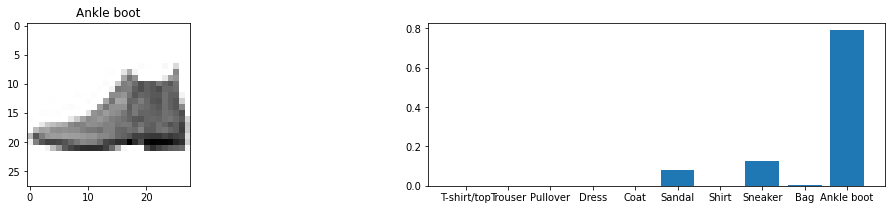

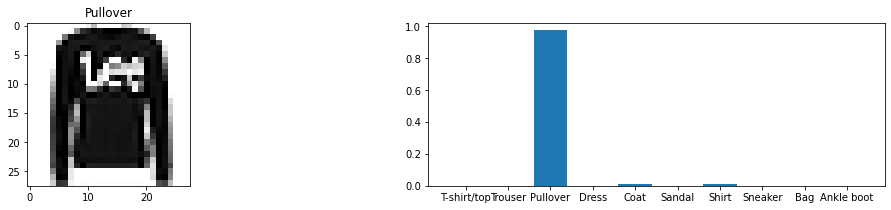

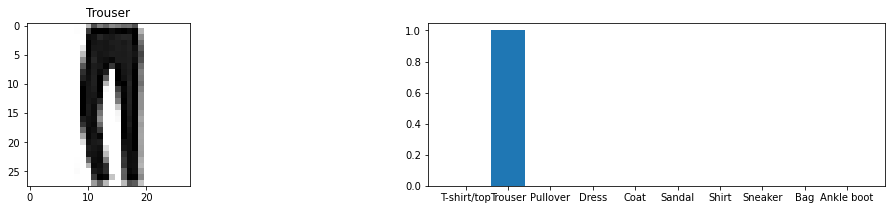

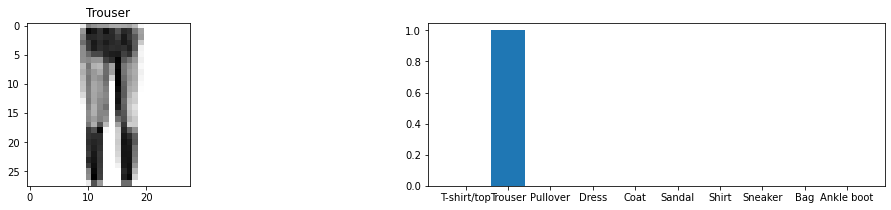

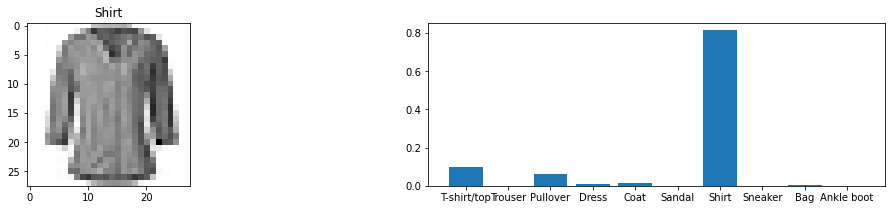

In [14]:
import matplotlib.pyplot as plt

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pred = model.forward(test_images.reshape(-1, 784))
pred = softmax(pred, axis=1)

for index in range(5):
    plt.figure(figsize=[18, 3])
    plt.subplot(1, 2, 1)
    plt.title(class_names[pred[index].argmax()])
    plt.imshow(test_images[index], cmap=plt.cm.binary)
    plt.subplot(1, 2, 2)
    plt.bar(range(10), pred[index])
    plt.xticks(range(10), class_names)
    plt.show()

In [15]:
accuracy = (np.argmax(pred, axis=1) == test_labels).sum() / len(test_labels)
print('accuracy :', accuracy)

accuracy : 0.869
